# Perhitungan Hartree Fock H₂ Menggunakan Python Program dengan STO-nG basis set

<p>Nama: Achmad Jaelani</p>
<p>Prodi: Fisika</p>
<p>Asal Instansi: Universitas Negeri Jakarta</p>

In [2]:
#--Import Necessary Library--
import sys
import math
import numpy as np
from scipy import special
from scipy import linalg
import scipy.optimize as sc
import matplotlib.pyplot as plt
import pandas as pd
import time

## Program utama Hartree-Fock
Cell dibawah ini berisi kelas utama perhitungan Hartree-Fock untuk molekul H2. Kelas HartreeFock mengambil input alpha, coefficient, dan variasi bond distance dalam list. Metode "run" pada kelas HartreeFock akan melakukan kalkulasi dan mengembalikan total energi (energi elektronik dan energi inti).

In [1]:
#--HF program--
class primitive_gaussian:

    def __init__(self, alpha, coeff, coordinates):

        self.alpha = alpha
        self.coeff = coeff
        self.coordinates = np.array(coordinates)
        self.A = (2.0 * alpha / math.pi)**0.75


class HartreeFock:
    #     param:
    #         alpha: array of alpha
    #         coeff: array of coefficient
    #         distance: array of variatonal bond distance
    #     method "run" return:
    #         total_energies: array of total energy at particular bond distance
    def __init__(self, alpha, coeff, distance):

        self.alpha = alpha
        self.coeff = coeff
        self.distance = distance

    def overlap(self, molecule):

        nbasis = len(molecule)

        S = np.zeros([nbasis, nbasis])

        for i in range(nbasis):
            for j in range(nbasis):

                nprimitives_i = len(molecule[i])
                nprimitives_j = len(molecule[j])

                for k in range(nprimitives_i):
                    for l in range(nprimitives_j):

                        N = molecule[i][k].A * molecule[j][l].A
                        p = molecule[i][k].alpha + molecule[j][l].alpha
                        q = molecule[i][k].alpha * molecule[j][l].alpha / p
                        Q = molecule[i][k].coordinates - molecule[j][
                            l].coordinates
                        Q2 = np.dot(Q, Q)

                        S[i, j] += N * molecule[i][k].coeff * molecule[j][
                            l].coeff * math.exp(
                                -q * Q2) * (math.pi / p)**(3 / 2)

        return S

    def kinetic(self, molecule):

        nbasis = len(molecule)

        T = np.zeros([nbasis, nbasis])

        for i in range(nbasis):
            for j in range(nbasis):

                nprimitives_i = len(molecule[i])
                nprimitives_j = len(molecule[j])

                for k in range(nprimitives_i):
                    for l in range(nprimitives_j):

                        N = molecule[i][k].A * molecule[j][l].A
                        cacb = molecule[i][k].coeff * molecule[j][l].coeff

                        p = molecule[i][k].alpha + molecule[j][l].alpha
                        P = molecule[i][k].alpha * molecule[i][
                            k].coordinates + molecule[j][l].alpha * molecule[
                                j][l].coordinates
                        Pp = P / p
                        PG = Pp - molecule[j][l].coordinates
                        PGx2 = PG[0] * PG[0]
                        PGy2 = PG[1] * PG[1]
                        PGz2 = PG[2] * PG[2]

                        q = molecule[i][k].alpha * molecule[j][l].alpha / p
                        Q = molecule[i][k].coordinates - molecule[j][
                            l].coordinates
                        Q2 = np.dot(Q, Q)

                        s = math.exp(
                            -q * Q2) * (math.pi / p)**(3 / 2) * N * cacb

                        T[i, j] += 3.0 * molecule[j][l].alpha * s
                        T[i, j] -= 2.0 * molecule[j][l].alpha * molecule[j][
                            l].alpha * s * (PGx2 + 0.5 / p)
                        T[i, j] -= 2.0 * molecule[j][l].alpha * molecule[j][
                            l].alpha * s * (PGy2 + 0.5 / p)
                        T[i, j] -= 2.0 * molecule[j][l].alpha * molecule[j][
                            l].alpha * s * (PGz2 + 0.5 / p)

        return T

    def boys(self, x, n):
        if x == 0:
            return 1.0 / (2 * n + 1)
        else:
            return special.gammainc(
                n + 0.5, x) * special.gamma(n + 0.5) * (1.0 /
                                                        (2 * x**(n + 0.5)))

    def electron_nuclear_attraction(self, molecule, Z):

        natoms = len(Z)
        nbasis = len(molecule)

        coordinates = []
        for i in range(nbasis):
            nprimitives_i = len(molecule[i])
            for j in range(nprimitives_i):
                coordinates.append(molecule[i][j].coordinates)

        coordinates = np.array(coordinates)
        coordinates = np.unique(coordinates, axis=0)

        V_ne = np.zeros([nbasis, nbasis])

        for atom in range(natoms):
            for i in range(nbasis):
                for j in range(nbasis):

                    nprimitives_i = len(molecule[i])
                    nprimitives_j = len(molecule[j])

                    for k in range(nprimitives_i):
                        for l in range(nprimitives_j):

                            N = molecule[i][k].A * molecule[j][l].A
                            cacb = molecule[i][k].coeff * molecule[j][l].coeff

                            p = molecule[i][k].alpha + molecule[j][l].alpha
                            P = molecule[i][k].alpha * molecule[i][
                                k].coordinates + molecule[j][
                                    l].alpha * molecule[j][l].coordinates
                            Pp = P / p

                            PG = P / p - coordinates[atom]

                            PG2 = np.dot(PG, PG)

                            q = molecule[i][k].alpha * molecule[j][l].alpha / p
                            Q = molecule[i][k].coordinates - molecule[j][
                                l].coordinates
                            Q2 = np.dot(Q, Q)

                            V_ne[i, j] += N * cacb * -Z[atom] * (
                                2.0 * math.pi / p) * math.exp(
                                    -q * Q2) * self.boys(p * PG2, 0)

        return V_ne

    def electron_electron_repulsion(self, molecule):

        nbasis = len(molecule)

        V_ee = np.zeros([nbasis, nbasis, nbasis, nbasis])

        for i in range(nbasis):
            for j in range(nbasis):
                for k in range(nbasis):
                    for l in range(nbasis):

                        nprimitives_i = len(molecule[i])
                        nprimitives_j = len(molecule[j])
                        nprimitives_k = len(molecule[k])
                        nprimitives_l = len(molecule[l])

                        for ii in range(nprimitives_i):
                            for jj in range(nprimitives_j):
                                for kk in range(nprimitives_k):
                                    for ll in range(nprimitives_l):

                                        N = molecule[i][ii].A * molecule[j][
                                            jj].A * molecule[k][
                                                kk].A * molecule[l][ll].A
                                        cicjckcl = molecule[i][ii].coeff * molecule[j][jj].coeff * \
                                                  molecule[k][kk].coeff * molecule[l][ll].coeff

                                        pij = molecule[i][ii].alpha + molecule[
                                            j][jj].alpha
                                        pkl = molecule[k][kk].alpha + molecule[
                                            l][ll].alpha

                                        Pij = molecule[i][ii].alpha*molecule[i][ii].coordinates +\
                                              molecule[j][jj].alpha*molecule[j][jj].coordinates
                                        Pkl = molecule[k][kk].alpha*molecule[k][kk].coordinates +\
                                              molecule[l][ll].alpha*molecule[l][ll].coordinates

                                        Ppij = Pij / pij
                                        Ppkl = Pkl / pkl

                                        PpijPpkl = Ppij - Ppkl
                                        PpijPpkl2 = np.dot(PpijPpkl, PpijPpkl)
                                        denom = 1.0 / pij + 1.0 / pkl

                                        qij = molecule[i][ii].alpha * molecule[
                                            j][jj].alpha / pij
                                        qkl = molecule[k][kk].alpha * molecule[
                                            l][ll].alpha / pkl

                                        Qij = molecule[i][
                                            ii].coordinates - molecule[j][
                                                jj].coordinates
                                        Qkl = molecule[k][
                                            kk].coordinates - molecule[l][
                                                ll].coordinates

                                        Q2ij = np.dot(Qij, Qij)
                                        Q2kl = np.dot(Qkl, Qkl)

                                        term1 = 2.0 * math.pi * math.pi / (
                                            pij * pkl)
                                        term2 = math.sqrt(math.pi /
                                                          (pij + pkl))
                                        term3 = math.exp(-qij * Q2ij)
                                        term4 = math.exp(-qkl * Q2kl)

                                        V_ee[
                                            i, j, k,
                                            l] += N * cicjckcl * term1 * term2 * term3 * term4 * self.boys(
                                                PpijPpkl2 / denom, 0)  # 3 more

        return V_ee

    def nuclear_nuclear_repulsion_energy(self, atom_coords, zlist):

        assert (len(atom_coords) == len(zlist))
        natoms = len(zlist)
        E_NN = 0
        for i in range(natoms):
            Zi = zlist[i]
            for j in range(natoms):
                if j > i:
                    Zj = zlist[j]
                    Rijx = atom_coords[i][0] - atom_coords[j][0]
                    Rijy = atom_coords[i][1] - atom_coords[j][1]
                    Rijz = atom_coords[i][2] - atom_coords[j][2]
                    Rijx_squared = Rijx * Rijx
                    Rijy_squared = Rijy * Rijy
                    Rijz_squared = Rijz * Rijz
                    Rij = math.sqrt(Rijx_squared + Rijy_squared + Rijz_squared)
                    E_NN += (Zi * Zj) / Rij

        return E_NN

    # scf
    def compute_G(self, density_matrix, Vee):
        nbasis_functions = density_matrix.shape[0]
        G = np.zeros((nbasis_functions, nbasis_functions))
        for i in range(nbasis_functions):
            for j in range(nbasis_functions):
                for k in range(nbasis_functions):
                    for l in range(nbasis_functions):
                        density = density_matrix[k, l]
                        J = Vee[i, j, k, l]
                        K = Vee[i, l, k, j]
                        G[i, j] += density * (J - 0.5 * K)
        return G

    def compute_density_matrix(self, mos, number_occupied_orbitals):
        nbasis_functions = mos.shape[0]
        density_matrix = np.zeros((nbasis_functions, nbasis_functions))
        # P = occ*CC_dagger
        occupation = 2.0
        for i in range(nbasis_functions):
            for j in range(nbasis_functions):
                # mo is (natomic_orbtials x nMOs)
                for oo in range(number_occupied_orbitals):
                    C = mos[i, oo]
                    C_dagger = mos[j, oo]
                    density_matrix[i, j] += occupation * C * C_dagger
        return density_matrix

    def compute_electronic_energy_expectation_value(self, density_matrix, T,
                                                    Vne, G):
        Hcore = T + Vne
        Hcore_ = 0
        electronic_energy = 0.0
        G_ = 0
        T_ = 0
        Vne_ = 0
        nbasis_functions = density_matrix.shape[0]
        for i in range(nbasis_functions):
            for j in range(nbasis_functions):
                electronic_energy += density_matrix[i, j] * (Hcore[i, j] +
                                                             0.5 * G[i, j])
                Hcore_ += density_matrix[i, j] * (Hcore[i, j])
                G_ += density_matrix[i, j] * 0.5 * G[i, j]
                T_ += density_matrix[i, j] * T[i, j]
                Vne_ += density_matrix[i, j] * Vne[i, j]

        return electronic_energy, G_, T_, Vne_

    def scf_cycle(self, molecular_terms, scf_parameters, molecule,
                  number_occupied_orbitals):

        S, T, Vne, Vee = molecular_terms
        tolerance, max_scf_steps = scf_parameters
        electronic_energy = 0.0
        nbasis_functions = len(molecule)
        density_matrix = np.zeros((nbasis_functions, nbasis_functions))
        elec_elec_rep = 0
        
        # 1. Enter into the SCF cycles
        for scf_step in range(max_scf_steps):

            electronic_energy_old = electronic_energy

            # 2. Compute the 2 electron term, and add it to the 1 electron term
            G = self.compute_G(density_matrix, Vee)

            # 3. Form F, make S unit, then get eigenvalues and eigenvectors - transform eigenvectors back (w.o unitS)
            F = T + Vne + G
            # S^{-1/2}
            S_inverse = linalg.inv(S)
            S_inverse_sqrt = linalg.sqrtm(S_inverse)
            # S^{-1/2} F S^{-1/2}
            F_unitS = np.dot(S_inverse_sqrt, np.dot(F, S_inverse_sqrt))
            eigenvalues, eigenvectors = linalg.eigh(F_unitS)
            mos = np.dot(S_inverse_sqrt, eigenvectors)

            # 4. Form new density matrix using MOs
            density_matrix = self.compute_density_matrix(
                mos, number_occupied_orbitals)

            # 5. Compute electronic_energy expectation value
            electronic_energy, G_, T_, Vne_ = self.compute_electronic_energy_expectation_value(
                density_matrix, T, Vne, G)

            # 6. Check convergence
            if abs(electronic_energy - electronic_energy_old) < tolerance:
                return electronic_energy, G_, T_, Vne_

        print("Warning: Convergence not met")
        return electronic_energy, G_, T_, Vne_

    def run(self, return_component=False):
        distances = self.distance  # in unit = bohr (a.u of position)
        molecule_coordinates = [[[0.0, 0.0, 0.0], [0.0, 0.0, distance]]
                                for distance in distances]

        total_energies = []
        electronic_energy_, G__, T__, Vne__, Enn_ = [], [], [], [], []
        for molecule_coordinate in molecule_coordinates:
            H1_1s = [
                primitive_gaussian(i, j, molecule_coordinate[0])
                for i, j in zip(self.alpha, self.coeff)
            ]
            H2_1s = [
                primitive_gaussian(i, j, molecule_coordinate[1])
                for i, j in zip(self.alpha, self.coeff)
            ]
            number_occupied_orbitals = 1
            zlist = [1.0, 1.0]
            atom_coords = [
                np.array(molecule_coordinate[0]),
                np.array(molecule_coordinate[1])
            ]
            molecule = [H1_1s, H2_1s]
            S = self.overlap(molecule)
            T = self.kinetic(molecule)
            Vne = self.electron_nuclear_attraction(molecule, [1.0, 1.0])
            Vee = self.electron_electron_repulsion(molecule)
            Enn = self.nuclear_nuclear_repulsion_energy(atom_coords, zlist)
            molecular_terms = [S, T, Vne, Vee]
            scf_parameters = [1e-5, 20]
            electronic_energy, G_, T_, Vne_ = self.scf_cycle(molecular_terms, scf_parameters,
                                               molecule,
                                               number_occupied_orbitals)
            total_energy = electronic_energy + Enn
            electronic_energy_.append(electronic_energy)
            G__.append(G_)
            T__.append(T_)
            Vne__.append(Vne_)
            Enn_.append(Enn)
            total_energies.append(total_energy)
            
        if return_component:
            component = {
                "R": distances,
                "Vee": G__,
                "T": T__,
                "Vne": Vne__,
                "Vnn": Enn_,
                "electronic_energy": electronic_energy_,
                "total_energy": total_energies
            }
            return component, total_energies
        else:
            return total_energies

Pada notebook ini, akan dibandingkan total energi yang dihasilkan oleh parameter alpha dan coefficient dengan sumber yang berbeda. Sumber yang pertama dari <a href="https://www.basissetexchange.org/">Basis Set Exchange</a>, sumber yang kedua berasal dari <a href="https://docs.google.com/document/d/1qLBIqWS3N0amesChpD1D60dlTB_vU5MW/edit?usp=sharing&ouid=107649864989116649741&rtpof=true&sd=true">Huzinaga</a>. Perhitungan menggunakan basis set dimulai dari STO-2G sampai STO-6G.

In [3]:
x = np.arange(0.5, 5.1, 0.1) # create variatonal bond distance, from 0.5 -> 3.5 with step 0.1

## Basis Set Exchange

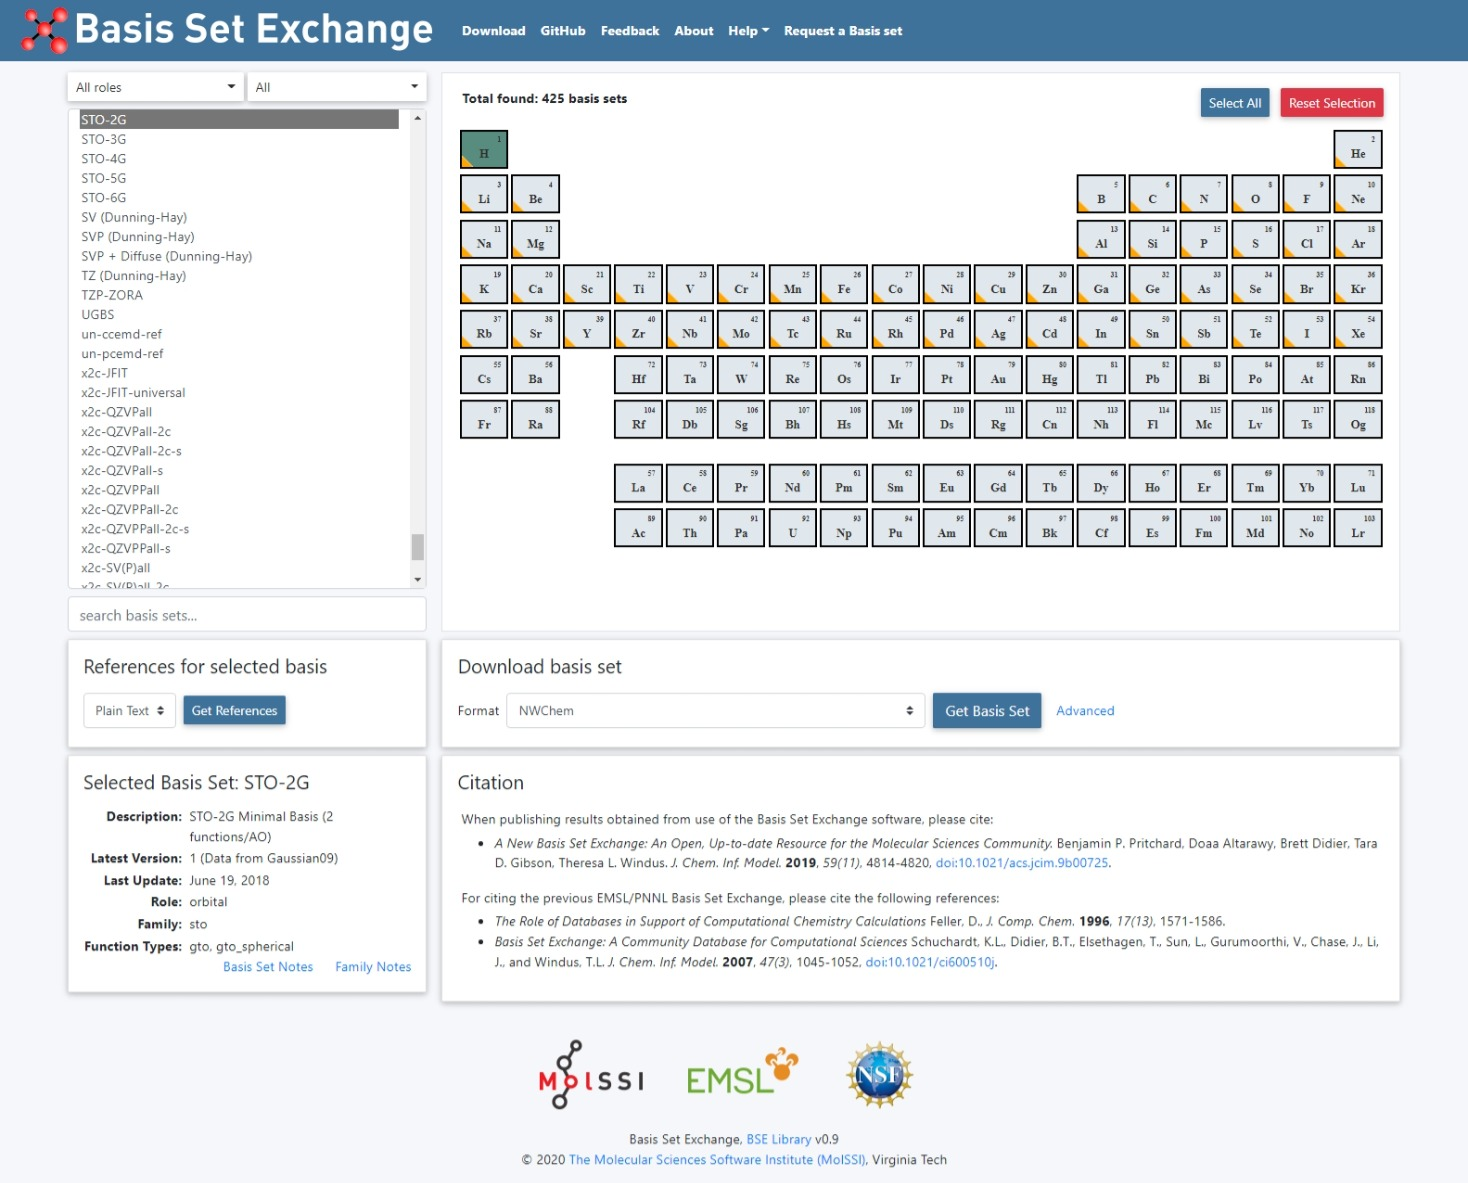

In [4]:
# BSE HF
BSE_2 = HartreeFock([0.1309756377E+01, 0.2331359749E+00],
                    [0.4301284983E+00, 0.6789135305E+00], x).run()

BSE_3 = HartreeFock([0.3425250914E+01, 0.6239137298E+00, 0.1688554040E+00],
                    [0.1543289673E+00, 0.5353281423E+00, 0.4446345422E+00],
                    x).run()

BSE_4 = HartreeFock(
    [0.8021420155E+01, 0.1467821061E+01, 0.4077767635E+00, 0.1353374420E+00],
    [0.5675242080E-01, 0.2601413550E+00, 0.5328461143E+00, 0.2916254405E+00],
    x).run()

BSE_5 = HartreeFock([
    0.1738354739E+02, 0.3185489246E+01, 0.8897299079E+00, 0.3037874103E+00,
    0.1144784984E+00
], [
    0.2214055312E-01, 0.1135411520E+00, 0.3318161484E+00, 0.4825700713E+00,
    0.1935721966E+00
], x).run()

BSE_6 = HartreeFock([
    0.3552322122E+02, 0.6513143725E+01, 0.1822142904E+01, 0.6259552659E+00,
    0.2430767471E+00, 0.1001124280E+00
], [
    0.9163596281E-02, 0.4936149294E-01, 0.1685383049E+00, 0.3705627997E+00,
    0.4164915298E+00, 0.1303340841E+00
], x).run()

## Huzinaga
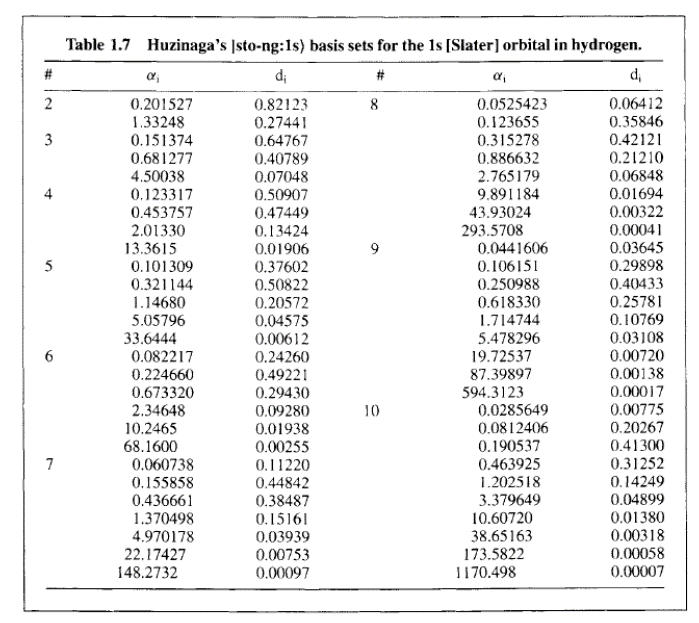

In [5]:
# Huzinaga HF
huzinaga_2 = HartreeFock([0.201527, 1.33248], [0.82123, 0.27441], x).run()

huzinaga_3 = HartreeFock([0.151374, 0.681277, 4.50038],
                         [0.64767, 0.40789, 0.07048], x).run()

huzinaga_4 = HartreeFock([0.123317, 0.453757, 2.01330, 13.3615],
                         [0.50907, 0.47449, 0.13424, 0.01906], x).run()

huzinaga_5 = HartreeFock([0.101309, 0.321144, 1.14680, 5.05796, 33.6444],
                         [0.37602, 0.50822, 0.20572, 0.04575, 0.00612],
                         x).run()

comp_huzinaga, huzinaga_6 = HartreeFock(
    [0.082217, 0.224660, 0.673320, 2.34648, 10.2465, 68.1600],
    [0.24260, 0.49221, 0.29430, 0.09280, 0.01938, 0.00255], x).run(return_component=True)

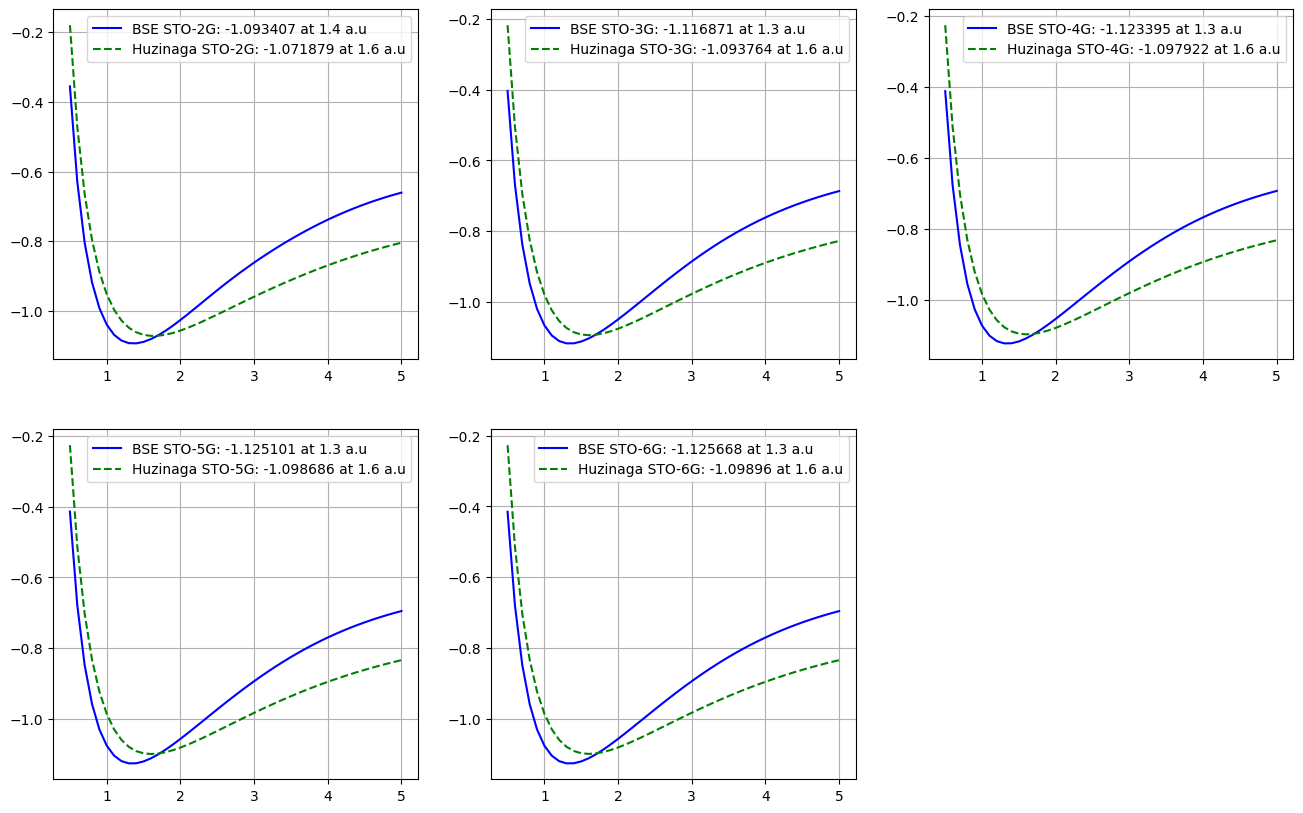

In [6]:
# Plotting

fig, ax = plt.subplots(2, 3, figsize=(16, 10))

result = ([BSE_2, BSE_3, BSE_4, BSE_5, BSE_6],
          [huzinaga_2, huzinaga_3, huzinaga_4, huzinaga_5, huzinaga_6])

for axs, energies_0, energies_1, counter in zip(ax.flatten(), result[0],
                                                result[1], range(5)):
    idx_0 = energies_0.index(min(energies_0))
    equ_0 = round(x[idx_0], 1)
    idx_1 = energies_1.index(min(energies_1))
    equ_1 = round(x[idx_1], 1)

    axs.plot(
        x,
        energies_0,
        "-b",
        label=
        f"BSE STO-{counter+2}G: {round(min(energies_0), 6)} at {equ_0} a.u")
    axs.plot(
        x,
        energies_1,
        "--g",
        label=
        f"Huzinaga STO-{counter+2}G: {round(min(energies_1), 6)} at {equ_1} a.u"
    )
    axs.grid()
    axs.legend()

ax[1, 2].remove()

plt.show()

## Kesimpulan

Terdapat perbedaan dari bentuk grafik yang dihasilkan dari perhitungan Hartree-Fock dengan sumber parameter yang berbeda. Begitupun untuk energi minimum dan *equilibrium bond length*.

Berikut perbandingan dengan perhitungan Molecular Orbital

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as scp

In [20]:
#--Main Integral--
def w(alpha, R):
    return alpha * R


def S(r):
    return (1 + r + ((1 / 3) * (r**2))) * np.exp(-r)


def S_(r):
    return (1 - r + ((1 / 3) * (r**2))) * np.exp(r)


def J(r):
    return -1 / r + np.exp(-2 * r) * (1 + (1 / r))


def K(r):
    return -np.exp(-r) * (1 + r)


def J_(r):
    return (1 / r) * (1 - (1 + (11 / 8) * r + (3 / 4) * (r**2) + (1 / 6) *
                           (r**3)) * np.exp(-2 * r))


def Ei(w):
    return scp.special.expi(w)


def K_(r):
    f_ = Ei(-4 * r)
    f__ = Ei(-2 * r)

    A = S_(r)
    term1 = ((25 / 8) - (23 / 4) * r - (3 * (r**2)) - (1 / 3) *
             (r**3)) * np.exp(-2 * r)
    term2 = (0.5772 + np.log(r)) * (S(r)**2)
    term3 = (A**2) * f_
    term4 = 2 * A * S(r) * f__
    try:
        return float((1 / 5) * (term1 + (6 / r) * (term2 + term3 - term4)))
    except:
        return complex((1 / 5) * (term1 + (6 / r) * (term2 + term3 - term4)))


def L(r):
    return np.exp(-r) * (r + 1 / 8 + 5 /
                         (16 * r)) + np.exp(-3 * r) * (-1 / 8 - 5 / (16 * r))

In [21]:
#--Integral and Energy--
def e_mo(alpha, R, mode):
    """
    Mode 1: ground state
    Mode 2: doubly excited state
    """
    r = alpha * R
    T = ((alpha**2) / (1 + S(r))) * (1 - 2 * K(r) - S(r))
    Vne = ((2 * alpha) / (1 + S(r))) * (-1 + J(r) + 2 * K(r))
    Vee = (alpha / (2 * ((1 + S(r))**2))) * (5 / 8 + J_(r) + 2 * K_(r) + 4 * L(r))
    Enn = 1 / R
    electronic_energy = T + Vne + Vee
    total_energy =  T + Vne + Vee + Enn
    if mode == 1:
        return (Vee, T, Vne, Enn, electronic_energy, total_energy)
    else:
        return ((alpha**2) / (1 - S(r))) * (1 + 2 * K(r) + S(r)) + (
            (2 * alpha) /
            (1 - S(r))) * (-1 + J(r) - 2 * K(r)) + (alpha / (2 * (
                (1 - S(r))**2))) * (5 / 8 + J_(r) + 2 * K_(r) -
                                    4 * L(r)) + 1 / R


def KE_MO(alpha, R, mode):
    r = alpha * R
    if mode == 1:
        return alpha * alpha / (1 + S(r)) * (1 - 2 * K(r) - S(r))
    else:
        return alpha * alpha / (1 - S(r)) * (1 + 2 * K(r) + S(r))


def PE_MO(alpha, R, mode):
    r = alpha * R
    
    if mode == 1:
        return ((2 * alpha) / (1 + S(r))) * (-1 + J(r) + 2 * K(r)) + (alpha / (2 * (
                    (1 + S(r))**2))) * (5 / 8 + J_(r) + 2 * K_(r) +
                                        4 * L(r)) + 1 / R
    else:
        return ((2 * alpha) /
                (1 - S(r))) * (-1 + J(r) - 2 * K(r)) + (alpha / (2 * (
                    (1 - S(r))**2))) * (5 / 8 + J_(r) + 2 * K_(r) -
                                        4 * L(r)) + 1 / R

In [22]:
# getting molecular orbitals result
Vee_, T_, Vne_, Vee_, Enn_ = [], [], [], [], []
electronic_energy_, total_energy_ = [], []

ja = 1

for i in x:
    Vee, T, Vne, Enn, electronic_energy, total_energy = e_mo(ja, i, 1)
    T_.append(T)
    Vne_.append(Vne)
    Vee_.append(Vee)
    Enn_.append(Enn)
    electronic_energy_.append(electronic_energy)
    total_energy_.append(total_energy)

In [23]:
# preparation component of MO
component = {
    "Vee_MO": Vee_,
    "T_MO": T_,
    "Vne_MO": Vne_,
    "Vnn_MO": Enn_,
    "electronic_energy_MO": electronic_energy_,
    "total_energy_MO": total_energy_
}

In [24]:
df1 = pd.DataFrame(component)
df2 = pd.DataFrame(comp_huzinaga)

In [25]:
df = pd.concat([df1, df2], axis=1)
df = df[["R", 'Vee_MO', 'Vee', 
          'T_MO', 'T', 
          'Vne_MO', 'Vne',
          'Vnn_MO', 'Vnn',
          'electronic_energy_MO', 'electronic_energy',
          'total_energy_MO', 'total_energy']]
components = ["Vee_e", "T_e" ,"Vne_e", "electronic_energy_e", "total_energy_e"]

for key in components:
    df[key+"(%)"] = abs((df[key[:-1]+"MO"] - df[key[:-2]])/df[key[:-1]+"MO"]) * 100

In [26]:
df.head()

,R,Vee_MO,Vee,T_MO,T,Vne_MO,Vne,Vnn_MO,Vnn,electronic_energy_MO,electronic_energy,total_energy_MO,total_energy,Vee_e(%),T_e(%),Vne_e(%),electronic_energy_e(%),total_energy_e(%)
0,0.5,0.615219,0.615197,0.948433,0.948186,-3.791131,-3.790569,2.000000,2.000000,-2.227479,-2.227186,-0.227479,-0.227186,0.003656,0.026035,0.014838,0.013159,0.128851
1,0.6,0.611246,0.611224,0.932244,0.932033,-3.724034,-3.723546,1.666667,1.666667,-2.180544,-2.180289,-0.513877,-0.513622,0.003537,0.022676,0.013109,0.011702,0.049655
2,0.7,0.606754,0.606734,0.915744,0.915565,-3.654574,-3.654155,1.428571,1.428571,-2.132076,-2.131856,-0.703505,-0.703285,0.003323,0.019556,0.011467,0.010310,0.031245
3,0.8,0.601811,0.601793,0.899344,0.899167,-3.584195,-3.583796,1.250000,1.250000,-2.083040,-2.082836,-0.833040,-0.832836,0.003067,0.019766,0.011152,0.009769,0.024426
4,0.9,0.596483,0.596466,0.883359,0.883159,-3.513987,-3.513569,1.111111,1.111111,-2.034144,-2.033943,-0.923033,-0.922832,0.002776,0.022646,0.011882,0.009878,0.021768


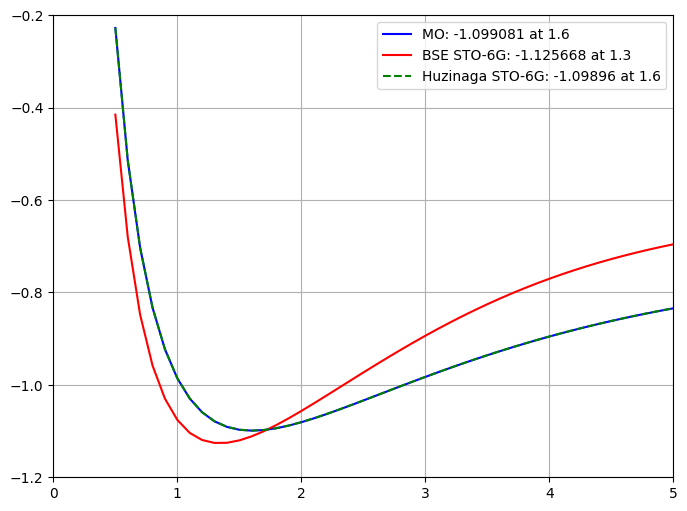

In [28]:
# plot
emo1 = []

ja = 1

for i in x:
    Vee, T, Vne, Enn, electronic_energy, total_energy = e_mo(ja, i, 1)
    emo1.append(total_energy)
# plot
indexes = (emo1.index(min(emo1)), BSE_6.index(min(BSE_6)),
           huzinaga_6.index(min(huzinaga_6)))
energies = (emo1, BSE_6, huzinaga_6)
plt.figure(figsize=(8, 6))
plt.plot(
    x,
    energies[0],
    "-b",
    label=f"MO: {round(min(energies[0]), 6)} at {round(x[indexes[0]], 1)}")
plt.plot(
    x,
    energies[1],
    "-r",
    label=
    f"BSE STO-6G: {round(min(energies[1]), 6)} at {round(x[indexes[1]], 1)}")
plt.plot(
    x,
    energies[2],
    "--g",
    label=
    f"Huzinaga STO-6G: {round(min(energies[2]), 6)} at {round(x[indexes[2]], 1)}"
)
plt.xlim(0, 5)
plt.ylim(-1.2, -0.2)
plt.grid()
plt.legend()
plt.show()